## 1. Instalação de Dependências

In [78]:
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn nbformat skl2onnx

## 2. Autenticação e Download do Dataset

Para acessar o dataset pelo Kaggle, crie um **API Token** em sua conta Kaggle:
1. No [Kaggle](https://www.kaggle.com/), clique no seu perfil > **Account**.
2. Role até **API** e clique em **Create New API Token**.
3. Faça upload do arquivo `kaggle.json` via painel lateral do Colab (ícone de pasta) na raiz do ambiente.


In [62]:
import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

# Copiar kaggle.json para ~/.config/kaggle, se estiver em /content
kaggle_src = '/content/kaggle.json'
kaggle_dest_dir = os.path.expanduser('~/.config/kaggle')
kaggle_dest_file = os.path.join(kaggle_dest_dir, 'kaggle.json')

if os.path.exists(kaggle_src):
    os.makedirs(kaggle_dest_dir, exist_ok=True)
    shutil.copy(kaggle_src, kaggle_dest_file)
    os.chmod(kaggle_dest_file, 0o600)
    print(f"Arquivo kaggle.json copiado para {kaggle_dest_file}")

# Autenticação
api = KaggleApi()
api.authenticate()

# Download e descompactação
api.dataset_download_files("fedesoriano/heart-failure-prediction", path="data", unzip=True)
print("Download concluído. Arquivos extraídos em 'data/'.")

Arquivo kaggle.json copiado para /root/.config/kaggle/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
Download concluído. Arquivos extraídos em 'data/'.


## 3. Carregando o Dataset

In [63]:
import pandas as pd

df = pd.read_csv('data/heart.csv')
display(df.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 4.Análise exploratória


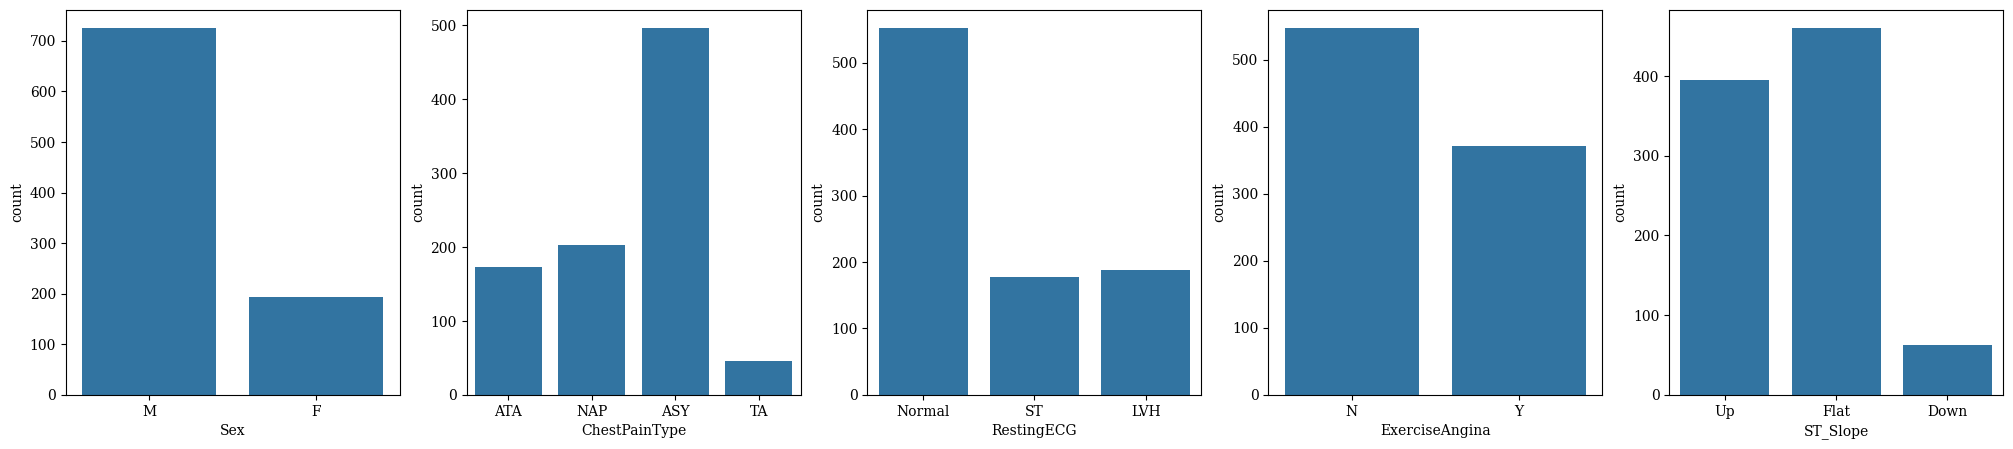

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

cat=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
plt.figure(figsize=(25,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  sns.countplot(x=cat[i],data=df)

In [65]:
df[df.HeartDisease == 0]['Sex'].value_counts()

,count
Sex,
M,267
F,143


In [66]:
df[df.HeartDisease == 1]['Sex'].value_counts()

,count
Sex,
M,458
F,50


## 5. Tratamento de valores ausentes

In [67]:
df['RestingBP'] = pd.to_numeric(df['RestingBP'], errors='coerce')
df['Cholesterol'] = pd.to_numeric(df['Cholesterol'], errors='coerce')

In [68]:
df['RestingBP']=df['RestingBP'].apply(lambda x: np.nan if x > 140 else x)
df['RestingBP']=df['RestingBP'].apply(lambda x: np.nan if x < 40 else x)
df['Cholesterol']=df['Cholesterol'].replace(0,np.nan)

# Verificar dados ausentes
print(df.isnull().sum())

Age                 0
Sex                 0
ChestPainType       0
RestingBP         221
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64


## 6.Normalização

In [69]:
# Codificação de variáveis categóricas
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ChestPainType'] = df['ChestPainType'].map({'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3})
df['RestingECG'] = df['RestingECG'].map({'Normal': 0, 'ST': 1, 'HVE': 2})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['ST_Slope'] = df['ST_Slope'].map({'Up': 0, 'Flat': 1, 'Down': 2})

In [72]:
categorical_columns = df.select_dtypes(include=['object']).columns


In [73]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore') # Ensure sparse=False to get a dense array
df_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))
df_encoded.columns = encoder.get_feature_names_out(categorical_columns)
df = df.drop(columns=categorical_columns).reset_index(drop=True)
df = pd.concat([df, df_encoded], axis=1)

In [74]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140.0,289.0,0,0.0,172,0,0.0,0,0
1,49,0,2,NaN,180.0,0,0.0,156,0,1.0,1,1
2,37,1,1,130.0,283.0,0,1.0,98,0,0.0,0,0
3,48,0,3,138.0,214.0,0,0.0,108,1,1.5,1,1
4,54,1,2,NaN,195.0,0,0.0,122,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,0,110.0,264.0,0,0.0,132,0,1.2,1,1
914,68,1,3,NaN,193.0,1,0.0,141,0,3.4,1,1
915,57,1,3,130.0,131.0,0,0.0,115,1,1.2,1,1
916,57,0,1,130.0,236.0,0,NaN,174,0,0.0,1,1


## 7. Treinamentos

In [75]:
from sklearn.model_selection import train_test_split

# Preencher valores numéricos ausentes com a média
df.fillna(df.mean(), inplace=True)

# Preencher valores categóricos ausentes com a moda (valor mais frequente)
df.fillna(df.mode().iloc[0], inplace=True)

# Definir variáveis preditoras (X) e alvo (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [76]:
# Preencher valores numéricos ausentes com a média
df.fillna(df.mean(), inplace=True)

# Preencher valores categóricos ausentes com a moda (valor mais frequente)
df.fillna(df.mode().iloc[0], inplace=True)

In [79]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx


# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Treinar o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Converter o modelo para ONNX
initial_type = [('float_input', FloatTensorType([None, X_train_resampled.shape[1]]))]
onnx_model = convert_sklearn(rf_model, initial_types=initial_type)
onnx_model.ir_version = 9
# Salvar o modelo ONNX
with open('random_forest_model.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())

print("Modelo ONNX salvo como 'random_forest_model.onnx'")


# Fazer predições
y_pred_rf = rf_model.predict(X_test)

Modelo ONNX salvo como 'random_forest_model.onnx'


In [80]:
from sklearn.neighbors import KNeighborsClassifier

# Treinar o modelo
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)

# Fazer predições
y_pred_knn = knn_model.predict(X_test)


In [81]:
from sklearn.linear_model import LogisticRegression

# Treinar o modelo
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

# Fazer predições
y_pred_lr = lr_model.predict(X_test)


## 8.Resultados

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Acurácia
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('KNN Accuracy:', accuracy_score(y_test, y_pred_knn))
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))

# Matriz de Confusão
print('Random Forest Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))

# Curva ROC
print('Random Forest AUC:', roc_auc_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.8858695652173914
KNN Accuracy: 0.5978260869565217
Logistic Regression Accuracy: 0.8478260869565217
Random Forest Confusion Matrix:
 [[70  7]
 [14 93]]
Random Forest AUC: 0.8891248937977909


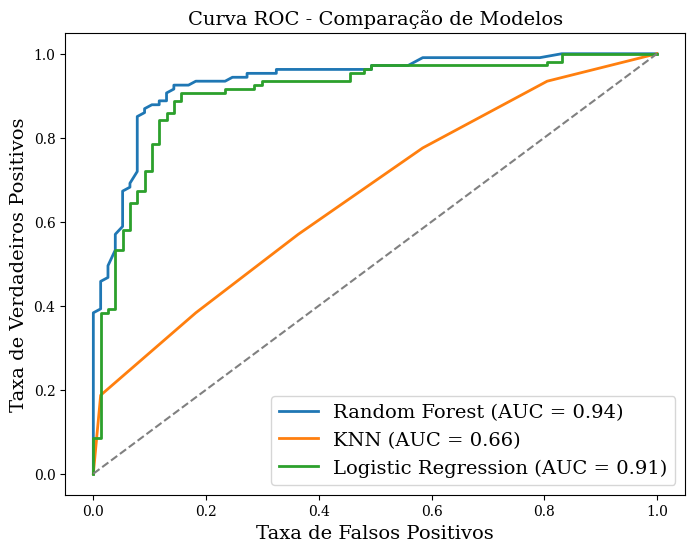

In [83]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Função para plotar matriz de confusão
def plot_confusion_matrix(y_test, y_pred, model_name):
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    plt.xlabel('Predito', fontsize=12)
    plt.show()

# Função para plotar a curva ROC com todos os modelos
def plot_roc_curve_all(y_test, models, model_names):
    plt.figure(figsize=(8, 6))

    for model, name in zip(models, model_names):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Adicionar a diagonal de referência
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
    plt.title('Curva ROC - Comparação de Modelos', fontsize=14)
    plt.legend(loc="lower right", prop={'family': 'serif', 'size': 14})
    plt.show()

# Lista de modelos e seus nomes (supondo que rf_model, knn_model e lr_model já estejam definidos)
models = [rf_model, knn_model, lr_model]
model_names = ["Random Forest", "KNN", "Logistic Regression"]

# Plotar todas as curvas ROC no mesmo gráfico
plot_roc_curve_all(y_test, models, model_names)





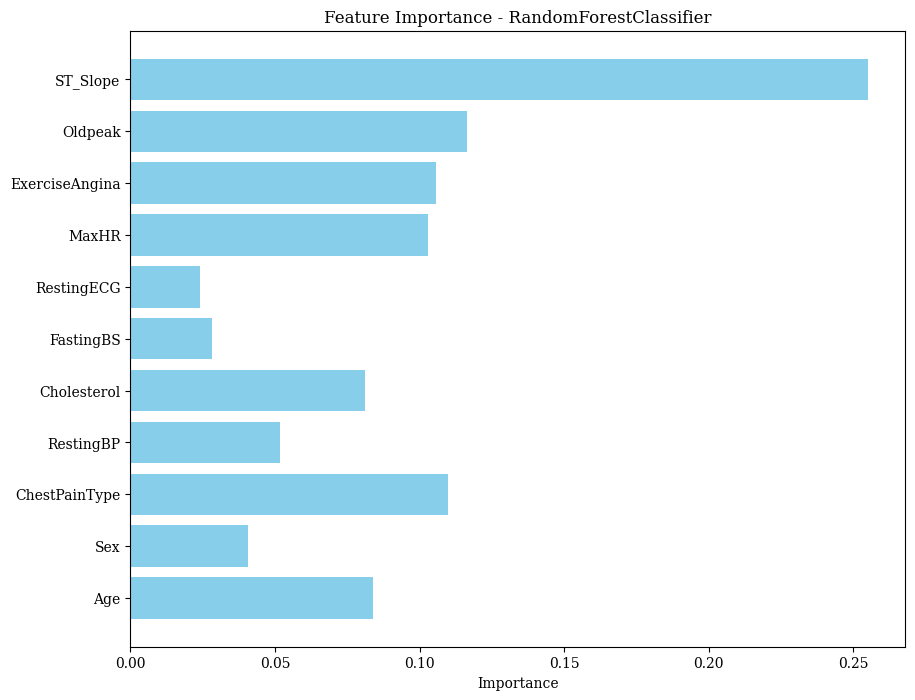

In [86]:

importances = rf_model.feature_importances_
feature_names = X.columns


plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - RandomForestClassifier')
plt.show()

In [87]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def display_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

print("RF");
display_metrics(y_test, y_pred_rf)
print("KNN");
display_metrics(y_test, y_pred_knn)
print("LR");
display_metrics(y_test, y_pred_lr)


RF
Accuracy: 0.8859
Precision: 0.9300
Recall: 0.8692
F1-Score: 0.8986
KNN
Accuracy: 0.5978
Precision: 0.6854
Recall: 0.5701
F1-Score: 0.6224
LR
Accuracy: 0.8478
Precision: 0.9072
Recall: 0.8224
F1-Score: 0.8627
